# GraphFrames User Guide (Python)

This notebook demonstrates examples from the [GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html).

## Requirements
This notebook requires Databricks Runtime for Machine Learning.

In [0]:
from functools import reduce
from pyspark.sql import functions as F
from graphframes import GraphFrame
from pyspark.sql.functions import col
from functools import reduce
import networkx as nx
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from graphframes import GraphFrame
from graphframes.examples import Graphs

## Create GraphFrames

Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named "id" which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: "src" (source vertex ID of edge) and "dst" (destination vertex ID of edge).

Both DataFrames can have arbitrary other columns. Those columns can represent vertex and edge attributes.

Create the vertices first:

In [0]:
vertices = spark.createDataFrame([
    ("a", "Alice", 34),
    ("b", "Bob", 36),
    ("c", "Charlie", 30),
    ("d", "David", 29),
    ("e", "Esther", 32),
    ("f", "Fanny", 36),
    ("g", "Gabby", 60)],
    ["id", "name", "age"])

And then some edges:

In [0]:
edges = spark.createDataFrame([
    ("a", "b", "friend"),
    ("b", "c", "follow"),
    ("c", "b", "follow"),
    ("f", "c", "follow"),
    ("e", "f", "follow"),
    ("e", "d", "friend"),
    ("d", "a", "friend"),
    ("a", "e", "friend")], 
    ["src", "dst", "relationship"])

Create a graph from these vertices and these edges:

In [0]:
g = GraphFrame(vertices, edges)
print(g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])


In [0]:
# This example graph also comes with the GraphFrames package.
from graphframes.examples import Graphs
same_g = Graphs(spark).friends()
print(same_g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])


In [0]:

def plot_directed_graph(gf, relationship):
  
  gplot = nx.DiGraph()
  edge_labels = {}
  
  plt.figure(figsize=(6, 7))
  for node in gf.vertices.select('id').take(1000):
    gplot.add_node(node['id'])
 
  for row in gf.edges.select('src', 'dst', relationship).take(1000):
    gplot.add_edge(row['src'], row['dst'])
    edge_labels[(row['src'], row['dst'])] = row[relationship]
       
  pos = nx.shell_layout(gplot)
  
  nx.draw(gplot,
          pos,
          with_labels=True, 
          font_weight='bold', 
          node_size=1800, 
          font_size=15, 
          width=2)
    
  nx.draw_networkx_edge_labels(gplot,
                               pos,
                               edge_labels=edge_labels,
                               font_color='green',
                               font_size=10,
                               font_weight='bold')

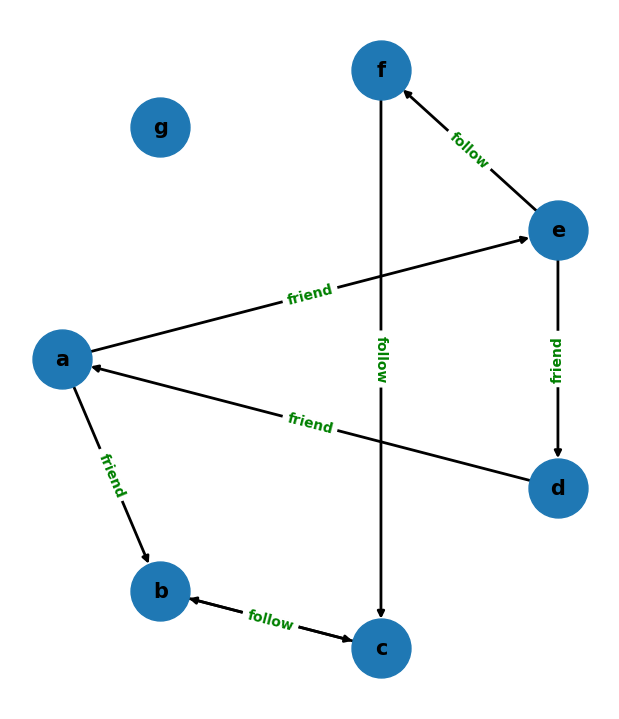

In [0]:
plot_directed_graph(g,'relationship')

## Basic graph and DataFrame queries

GraphFrames provide several simple graph queries, such as node degree.

Also, since GraphFrames represent graphs as pairs of vertex and edge DataFrames, it is easy to make powerful queries directly on the vertex and edge DataFrames. Those DataFrames are made available as vertices and edges fields in the GraphFrame.

In [0]:
display(g.vertices)

id,name,age
a,Alice,34
b,Bob,36
c,Charlie,30
d,David,29
e,Esther,32
f,Fanny,36
g,Gabby,60


In [0]:
display(g.edges)

src,dst,relationship
a,b,friend
b,c,follow
c,b,follow
f,c,follow
e,f,follow
e,d,friend
d,a,friend
a,e,friend


The incoming degree of the vertices:

In [0]:
display(g.inDegrees)

id,inDegree
b,2
c,2
f,1
d,1
a,1
e,1


The outgoing degree of the vertices:

In [0]:
display(g.outDegrees)

id,outDegree
a,2
b,1
c,1
f,1
e,2
d,1


The degree of the vertices:

In [0]:
display(g.degrees)

id,degree
b,3
a,3
c,3
f,2
e,3
d,2


You can run queries directly on the vertices DataFrame. For example, we can find the age of the youngest person in the graph:

In [0]:
youngest = g.vertices.groupBy().min("age")
display(youngest)

min(age)
29


You can also run queries on the edges DataFrame. For example, count the number of _follow_ relationships in the graph:

In [0]:
numFollows = g.edges.filter("relationship = 'follow'").count()
print("The number of follow edges is", numFollows)

The number of follow edges is 4


## Motif finding

Using motifs you can build more complex relationships involving edges and vertices. The following cell finds the pairs of vertices with edges in both directions between them. The result is a DataFrame, in which the column names are given by the motif keys.

See the [GraphFrame User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#motif-finding) for more details on the API.

In [0]:
# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
display(motifs)

a,e,b,e2
"List(c, Charlie, 30)","List(c, b, follow)","List(b, Bob, 36)","List(b, c, follow)"
"List(b, Bob, 36)","List(b, c, follow)","List(c, Charlie, 30)","List(c, b, follow)"


In [0]:
motifs.cache()

DataFrame[a: struct<id:string,name:string,age:bigint>, e: struct<src:string,dst:string,relationship:string>, b: struct<id:string,name:string,age:bigint>, e2: struct<src:string,dst:string,relationship:string>]

In [0]:
display(motifs.printSchema())

root
 |-- a: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- age: long (nullable = true)
 |-- e: struct (nullable = false)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- relationship: string (nullable = true)
 |-- b: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- age: long (nullable = true)
 |-- e2: struct (nullable = false)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- relationship: string (nullable = true)



Because the result is a DataFrame, more complex queries can be built on top of the motif. The following cell finds all the reciprocal relationships in which one person is older than 30:

In [0]:
filtered = motifs.filter("b.age > 30 or a.age > 30")
display(filtered)

a,e,b,e2
"List(c, Charlie, 30)","List(c, b, follow)","List(b, Bob, 36)","List(b, c, follow)"
"List(b, Bob, 36)","List(b, c, follow)","List(c, Charlie, 30)","List(c, b, follow)"


## Subgraphs

GraphFrames provides APIs for building subgraphs by filtering on edges and vertices. These filters can be composed together, for example the following subgraph only includes people who are more than 30 years old and have friends who are more than 30 years old.

In [0]:
g2 = g.filterEdges("relationship = 'friend'").filterVertices("age > 30").dropIsolatedVertices()

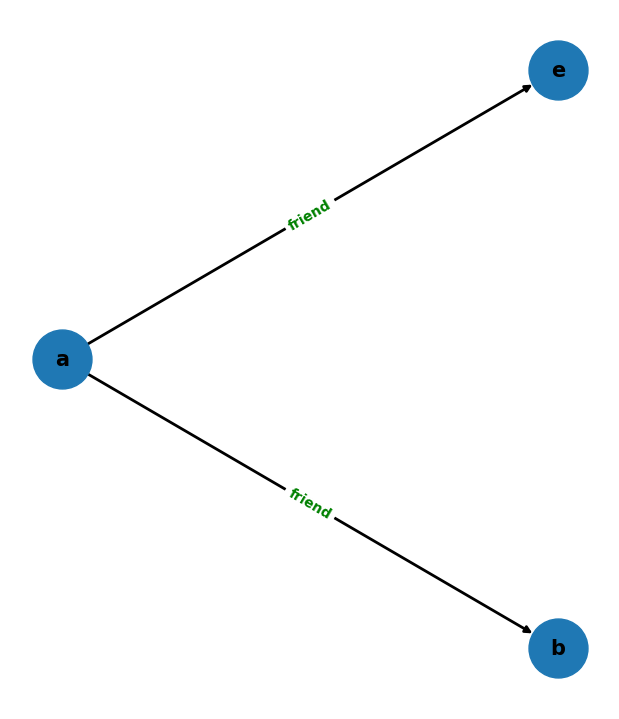

In [0]:
plot_directed_graph(g2,'relationship')

In [0]:
display(g2.vertices)

id,name,age
a,Alice,34
b,Bob,36
e,Esther,32


In [0]:
display(g2.edges)

src,dst,relationship
a,b,friend
a,e,friend
